<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#A-neural-network-in-numpy" data-toc-modified-id="A-neural-network-in-numpy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A neural network in numpy</a></span></li><li><span><a href="#Getting-the-data" data-toc-modified-id="Getting-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the data</a></span></li><li><span><a href="#Simple-postprocessing" data-toc-modified-id="Simple-postprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple postprocessing</a></span><ul class="toc-item"><li><span><a href="#Add-station-information-with-embeddings" data-toc-modified-id="Add-station-information-with-embeddings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Add station information with embeddings</a></span></li><li><span><a href="#What-about-a-neural-network?" data-toc-modified-id="What-about-a-neural-network?-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>What about a neural network?</a></span></li></ul></li><li><span><a href="#Adding-more-variables" data-toc-modified-id="Adding-more-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Adding more variables</a></span><ul class="toc-item"><li><span><a href="#Simple-linear-net-with-auxiliary-variables" data-toc-modified-id="Simple-linear-net-with-auxiliary-variables-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Simple linear net with auxiliary variables</a></span></li><li><span><a href="#Auxiliary-variables-with-station-embeddings" data-toc-modified-id="Auxiliary-variables-with-station-embeddings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Auxiliary variables with station embeddings</a></span></li><li><span><a href="#Neural-network" data-toc-modified-id="Neural-network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Neural network</a></span></li><li><span><a href="#A-more-complex-neural-network" data-toc-modified-id="A-more-complex-neural-network-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>A more complex neural network</a></span></li><li><span><a href="#Hmmm,-weird..." data-toc-modified-id="Hmmm,-weird...-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Hmmm, weird...</a></span></li></ul></li><li><span><a href="#A-longer-training-period" data-toc-modified-id="A-longer-training-period-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A longer training period</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Neural networks for post-processing NWP forecasts

In [166]:
# Imports 
import numpy as np
import sys
sys.path.append('../')   # This is where all the python files are!
from importlib import reload
import utils; reload(utils)
from utils import *
import keras_models; reload(keras_models)
from keras_models import *
from losses import crps_cost_function
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_context('poster')

Anaconda environment: cbrain_gpu
Linux 4.4.0-101-generic


In [7]:
# Basic setup
# DATA_DIR = '/Volumes/STICK/data/ppnn_data/'  # Mac
DATA_DIR = '/project/meteo/w2w/C7/ppnn_data/'   # LMU

## A neural network in numpy

2 inputs, 1 hidden layer with 5 nodes, 2 outputs

In [12]:
# Create some mock data
n_samples = 1000
features = np.random.rand(n_samples, 2)
targets = 10 * features[:, 0] * features[:, 1] + 0.3 * np.random.rand(n_samples) - 0.15
features.shape, targets.shape

((1000, 2), (1000,))

In [13]:
features[:3], targets[:3]

(array([[ 0.87719419,  0.59026528],
        [ 0.04778934,  0.33822739],
        [ 0.35290574,  0.13613203]]),
 array([ 5.03090619,  0.14209776,  0.42142432]))

In [85]:
w1 = np.random.rand(2, 5)
b1 = np.random.rand(5)

In [15]:
hidden = np.dot(features, w1) + b1
hidden.shape

(1000, 5)

In [16]:
def relu(z):
    return np.maximum(0, z)

In [86]:
hidden = relu(hidden)
hidden.shape

(1000, 5)

In [87]:
w2 = np.random.rand(5, 1)
b2 = np.random.rand(1)

In [19]:
output = np.dot(hidden, w2) + b2
output.shape

(1000, 1)

In [22]:
output[:3]

array([[ 3.23453558],
       [ 2.06376869],
       [ 2.31335353]])

In [20]:
def forward_pass(features, weights, biases):
    hidden = relu(np.dot(features, weights[0]) + biases[0])
    return np.dot(hidden, weights[1]) + biases[1]

In [23]:
forward_pass(features, [w1, w2], [b1, b2])[:3]

array([[ 3.23453558],
       [ 2.06376869],
       [ 2.31335353]])

In [35]:
def loss(predictions, targets):
    """Mean squared error"""
    return np.abs((np.squeeze(predictions) - targets) ** 2)

In [36]:
loss(output, targets)

1.600690458970484

In [38]:
def dloss(predictions, targets):
    return np.squeeze(predictions) - targets

In [78]:
def drelu(z):
    return 1. * (z > 0)

In [47]:
delta2 = output - targets.reshape(output.shape)
delta2.shape

(1000, 1)

In [48]:
dw2 = np.dot(hidden.T, delta2)
dw2.shape

(5, 1)

In [49]:
db2 = np.sum(delta2, axis=0)
db2.shape

(1,)

In [55]:
delta1 = np.dot(delta2, w2.T)  * drelu(hidden)
delta1.shape

(1000, 5)

In [57]:
dw1 = np.dot(features.T, delta1)
dw1.shape

(2, 5)

In [58]:
db1 = np.sum(delta1, axis=0)
db1.shape

(5,)

In [114]:
import pdb

In [131]:
def backward_pass(features, targets, weights, biases, lr=0.0001):
    # Forward pass
    #pdb.set_trace()
    hidden = relu(np.dot(features, weights[0]) + biases[0])
    outp = np.dot(hidden, weights[1]) + biases[1]
    
    # Compute loss
    loss = np.mean((np.squeeze(outp) - targets) ** 2)
    print('Loss:', loss)
    
    # Compute Ds
    delta2 = outp - targets.reshape(output.shape)
    dw2 = np.dot(hidden.T, delta2)
    db2 = np.sum(delta2, axis=0)
    delta1 = np.dot(delta2, weights[1].T)  * drelu(hidden)
    dw1 = np.dot(features.T, delta1)
    db1 = np.sum(delta1, axis=0)
    
    # Update parameters
    weights[0] -= lr * dw1
    biases[0] -= lr * db1
    weights[1] -= lr * dw2
    biases[1] -= lr * db2

In [174]:
w1 = np.random.rand(2, 5)
b1 = np.random.rand(5)
w2 = np.random.rand(5, 1)
b2 = np.random.rand(1)

In [175]:
weights = [w1, w2]
biases = [b1, b2]
weights[0]

array([[ 0.20578793,  0.78753153,  0.55609003,  0.04458742,  0.22208434],
       [ 0.6765867 ,  0.52794629,  0.24290937,  0.3831397 ,  0.96958867]])

In [203]:
for i in range(10):
    backward_pass(features, targets, weights, biases, lr=0.0001)

Loss: 0.198957801803
Loss: 0.198787412709
Loss: 0.198621072284
Loss: 0.198459425615
Loss: 0.198301056583
Loss: 0.198143815494
Loss: 0.197988257048
Loss: 0.197832674504
Loss: 0.197679744971
Loss: 0.197529295423


In [204]:
forward_pass(features, [w1, w2], [b1, b2])[:3]

array([[ 5.20619023],
       [ 0.07565037],
       [ 0.35724453]])

In [205]:
output[:3]

array([[ 3.23453558],
       [ 2.06376869],
       [ 2.31335353]])

## Getting the data

Our forecasts are ECMWF forecasts of temperature taken from the TIGGE dataset which contain forecasts from 2008 to now upscaled to 40km grid spacing. Specifically we look at 48h forecasts initialized at 00UTC. 

The observations are from around 500 DWD surface stations. The forecast data was bilinearly interpolated to the station locations.

We will use all of 2015 for training the model and all of 2016 to test how well the model performs.

In [8]:
train_dates = ['2015-01-01', '2016-01-01']
test_dates =  ['2016-01-01', '2017-01-01']
train_set, test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates)

train set contains 365 days
test set contains 366 days


The raw ensemble contains 50 ensemble members. We take the mean and standard deviations of these 50 values which is a good approximation since temperature is normally distributed.

In [9]:
train_set.feature_names

['t2m_fc_mean', 't2m_fc_std']

In total we have around 500 stations for every day with some missing observation data. In total that makes around 180k samples.

In [44]:
len(np.unique(train_set.station_ids))

500

In [11]:
train_set.features.shape, train_set.targets.shape

((180849, 2), (180849,))

In [48]:
def plot_fc(data_set, idx, distr='pdf'):
    fc = data_set.features[idx] * data_set.scale_factors
    obs = data_set.targets[idx]
    x = np.linspace(fc[0] - 5 * fc[1], fc[0] + 5 * fc[1], 100)
    if distr == 'pdf':
        y = norm.pdf(x, fc[0], fc[1])
    elif distr == 'cdf':
        y = norm.cdf(x, fc[0], fc[1])
    else:
        raise Exception
    plt.plot(x, y)
    plt.axvline(obs, color='red')
    plt.xlabel('Temperature [C]')
    plt.show()

The goal of post-processing is to produce a sharp but reliable distribution.

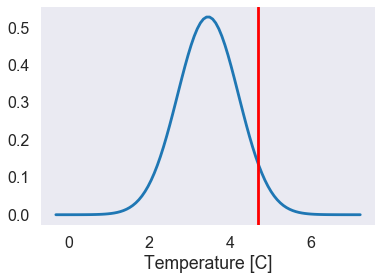

In [49]:
plot_fc(train_set, 1001)

To measure the skill of the forecast, we use the CRPS: 


$$ \mathrm{crps}(F, y) = \int_{-\infty}^{\infty} [F(t) - H(t-y)]^2\mathrm{d}t, $$

where $F(t)$ is the forecast CDF and $H(t-y)$ is the Heaviside function.

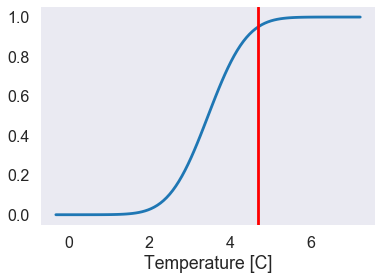

In [50]:
plot_fc(train_set, 1001, 'cdf')

For a normal distribution we can easily compute the CRPS from the mean and standard deviation for the raw ensemble, which is the score we want to improve.

In [47]:
np.mean(crps_normal(
    test_set.features[:, 0] * test_set.scale_factors[0], 
    test_set.features[:, 1] * test_set.scale_factors[1], 
    test_set.targets
))

1.1518655803872713

## Simple postprocessing

The most common post-processing technique for this sort of problem is called Ensemble Model Output Statistic (Gneiting et al. 2005). In this technique, the goal is to find a distribution
$$ \mathcal{N}(a + bX, c + dS^2), $$
where $X$ is the raw ensemble mean and $S$ is the raw ensemble standard deviation, so that 
$$ \min_{a, b, c, d} \frac{1}{N_{\mathrm{sample}}} \sum_{i = 1}^{N_{\mathrm{sample}}} crps(\mathcal{N}(a + bX, c + dS^2), y_i)$$
The minimum over all samples is found using some optimization algorithm. We can also view this as a network graph

![EMOS_Network](EMOS_Network.png)

There are two commonly used variant of EMOS: Global EMOS where all stations share the same coefficients and training happens over a rolling window of e.g. 25 days and local EMOS where each station is fit separately with a longer training window (e.g. 1 year).

The CRPS scores for 2016 are:
- Global EMOS: 1.01
- Local EMOS: 0.92

This is the benchmark for our networks.

Let's start by fitting a very simple fully connected network like this:
![fc_network](fc_network.png)

In [59]:
# Build the network using Keras
fc_model = Sequential([
    Dense(2, input_dim=2)
])

In [60]:
fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [61]:
fc_model.compile(Adam(0.1), crps_cost_function)

In [62]:
fc_model.fit(train_set.features, train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.7875     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.7402     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.3722     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 2.0094     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.6630     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.3781     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.1932     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.1077     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0795     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 1.0720     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 1.0701     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 1.0695     
E

In [65]:
# Now display the score for 2016
fc_model.evaluate(test_set.features, test_set.targets, 4096, verbose=0)

1.0128482668843812

So we basically get the same score as global EMOS, which is what we would expect.

### Add station information with embeddings

The stations probably differ a lot in their post-processing characteristics. So we want to include this somehow. In local EMOS, we wit a separate model for each station, but this takes a long time and doesn't optimally use all the training data.

Embeddings are a neural network technique which provide a natural way to include station information. An embedding is a mapping from a discrete object, in our case the station ID, to a vector. The elements of the vector are learned by the network just like the other weights and biases and represent some extra information about each station.

In [127]:
emb_size = 2
max_id = int(np.max([train_set.cont_ids.max(), test_set.cont_ids.max()]))
max_id

536

In [128]:
features_inp = Input(shape=(2,))
id_inp = Input(shape=(1,))
emb = Embedding(max_id+1, emb_size)(id_inp)
emb = Flatten()(emb)
x = Concatenate()([features_inp, emb])
outp = Dense(2)(x)
emb_model = Model([features_inp, id_inp], outp)

In [129]:
emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 2)          1074        input_8[0][0]                    
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 2)             0           embedding_4[0][0]                
___________________________________________________________________________________________

In [130]:
emb_model.compile(Adam(0.1), crps_cost_function)

In [131]:
emb_model.fit([train_set.features, train_set.cont_ids], train_set.targets,
              epochs=20, batch_size=4096);

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 4.1737     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 2.7637     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 2.2830     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.8283     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.4332     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.1565     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0219     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9802     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9714     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9697     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9695     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9694     
E

In [132]:
emb_model.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.91235853035206693

This score is about 1% better than local EMOS and is much faster.

### What about a neural network?

So far the network we used were simple linear networks, nothing neural about them. Let's try adding a hidden layer.

In [134]:
def create_emb_hidden_model(hidden_nodes, n_features=2, activation='relu'):
    features_inp = Input(shape=(n_features,))
    id_inp = Input(shape=(1,))
    emb = Embedding(max_id+1, emb_size)(id_inp)
    emb = Flatten()(emb)
    x = Concatenate()([features_inp, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation)(x)
    outp = Dense(2)(x)
    return Model([features_inp, id_inp], outp)

In [140]:
neural_net = create_emb_hidden_model([10])
neural_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 2)          1074        input_12[0][0]                   
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 2)             0           embedding_6[0][0]                
___________________________________________________________________________________________

In [141]:
neural_net.compile(Adam(0.1), crps_cost_function)

In [142]:
neural_net.fit([train_set.features, train_set.cont_ids], train_set.targets, 
               epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 3.6254     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 1.1819     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 1.0104     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 0.9840     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 0.9788     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 0.9762     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 0.9744     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9733     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9718     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9692     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9681     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9691     
E

In [143]:
neural_net.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.92509797401748739

In [154]:
neural_net = create_emb_hidden_model([1024, 1024])
neural_net.compile(Adam(0.01), crps_cost_function)
neural_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_11 (Embedding)         (None, 1, 2)          1074        input_22[0][0]                   
____________________________________________________________________________________________________
input_21 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
flatten_11 (Flatten)             (None, 2)             0           embedding_11[0][0]               
___________________________________________________________________________________________

In [155]:
neural_net.fit([train_set.features, train_set.cont_ids], train_set.targets, 
               epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 1s - loss: 1.6733     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 0.9787     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 0.9740     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 0.9719     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 0.9663     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 0.9646     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 0.9606     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 0.9655     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 0.9639     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9670     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9572     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9599     
E

In [152]:
neural_net.evaluate([test_set.features, test_set.cont_ids], test_set.targets, 4096, 0)

0.9220620622779756

## Adding more variables

So far we have only used the temperature forecast as input but really we have a lot more variables from each forecast which might give us more information about the weather situation. 

In traditional post-processing there are techniques to utilize these auxiliary variables, called boosting techniques. 

Here are the benchmark scores from Sebastian's boosting experiments:
- global boosting: 0.97
- local boosting: 0.87

As a first attempt we can simply throw in these extra variables to our standard network and see what happens. 

In [156]:
aux_dict

OrderedDict([('data_aux_geo_interpolated.nc',
              ['orog', 'station_alt', 'station_lat', 'station_lon']),
             ('data_aux_pl500_interpolated_00UTC.nc',
              ['u_pl500_fc', 'v_pl500_fc', 'gh_pl500_fc']),
             ('data_aux_pl850_interpolated_00UTC.nc',
              ['u_pl850_fc', 'v_pl850_fc', 'q_pl850_fc']),
             ('data_aux_surface_interpolated_00UTC.nc',
              ['cape_fc', 'sp_fc', 'tcc_fc']),
             ('data_aux_surface_more_interpolated_part1_00UTC.nc',
              ['sshf_fc', 'slhf_fc', 'u10_fc', 'v10_fc']),
             ('data_aux_surface_more_interpolated_part2_00UTC.nc',
              ['ssr_fc', 'str_fc', 'd2m_fc', 'sm_fc'])])

In [162]:
#aux_train_set, aux_test_set = get_train_test_sets(DATA_DIR, train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_15_16.pkl', 'rb') as f:
    aux_train_set, aux_test_set = pickle.load(f)

In [165]:
print(aux_train_set.feature_names)
len(aux_train_set.feature_names)

['t2m_fc_mean', 't2m_fc_std', 'orog', 'station_alt', 'station_lat', 'station_lon', 'u_pl500_fc_mean', 'u_pl500_fc_std', 'v_pl500_fc_mean', 'v_pl500_fc_std', 'gh_pl500_fc_mean', 'gh_pl500_fc_std', 'u_pl850_fc_mean', 'u_pl850_fc_std', 'v_pl850_fc_mean', 'v_pl850_fc_std', 'q_pl850_fc_mean', 'q_pl850_fc_std', 'cape_fc_mean', 'cape_fc_std', 'sp_fc_mean', 'sp_fc_std', 'tcc_fc_mean', 'tcc_fc_std', 'sshf_fc_mean', 'sshf_fc_std', 'slhf_fc_mean', 'slhf_fc_std', 'u10_fc_mean', 'u10_fc_std', 'v10_fc_mean', 'v10_fc_std', 'ssr_fc_mean', 'ssr_fc_std', 'str_fc_mean', 'str_fc_std', 'd2m_fc_mean', 'd2m_fc_std', 'sm_fc_mean', 'sm_fc_std']


40

As with temperature, we took the ensemble mean and standard deviation of all auxiliary variables (except for the constants). Now we can build the same network as earlier but with 40 inputs.

### Simple linear net with auxiliary variables

In [167]:
aux_fc_model = Sequential([
    Dense(2, input_dim=40)
])
aux_fc_model.compile(Adam(0.1), crps_cost_function)
aux_fc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 2)                 82        
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


In [168]:
aux_fc_model.fit(aux_train_set.features, aux_train_set.targets, epochs=20, batch_size=4096)

Epoch 1/20
180849/180849 [==============================] - 0s - loss: 3.9703     
Epoch 2/20
180849/180849 [==============================] - 0s - loss: 1.7954     
Epoch 3/20
180849/180849 [==============================] - 0s - loss: 1.4347     
Epoch 4/20
180849/180849 [==============================] - 0s - loss: 1.2368     
Epoch 5/20
180849/180849 [==============================] - 0s - loss: 1.1294     
Epoch 6/20
180849/180849 [==============================] - 0s - loss: 1.0710     
Epoch 7/20
180849/180849 [==============================] - 0s - loss: 1.0373     
Epoch 8/20
180849/180849 [==============================] - 0s - loss: 1.0159     
Epoch 9/20
180849/180849 [==============================] - 0s - loss: 1.0008     
Epoch 10/20
180849/180849 [==============================] - 0s - loss: 0.9902     
Epoch 11/20
180849/180849 [==============================] - 0s - loss: 0.9822     
Epoch 12/20
180849/180849 [==============================] - 0s - loss: 0.9772     
E

In [170]:
aux_fc_model.evaluate(aux_test_set.features, aux_test_set.targets, 4096, 0)

0.92275059023247719

So we get a big improvement from 1.01 for only temperature. we are also doing better than global boosting. Next let's include our station embeddings.

### Auxiliary variables with station embeddings

In [189]:
aux_emb_model = create_emb_hidden_model([], n_features=40)
aux_emb_model.compile(Adam(0.01), crps_cost_function)
aux_emb_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_34 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_17 (Embedding)         (None, 1, 2)          1074        input_34[0][0]                   
____________________________________________________________________________________________________
input_33 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_17 (Flatten)             (None, 2)             0           embedding_17[0][0]               
___________________________________________________________________________________________

In [190]:
aux_emb_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
                   epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 2.7484     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 1.9120     
Epoch 3/50
180849/180849 [==============================] - 1s - loss: 1.6414     
Epoch 4/50
180849/180849 [==============================] - 1s - loss: 1.4628     
Epoch 5/50
180849/180849 [==============================] - 1s - loss: 1.3345     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 1.2397     
Epoch 7/50
180849/180849 [==============================] - 1s - loss: 1.1709     
Epoch 8/50
180849/180849 [==============================] - 1s - loss: 1.1164     
Epoch 9/50
180849/180849 [==============================] - 1s - loss: 1.0768     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 1.0460     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 1.0223     
Epoch 12/50
180849/180849 [==============================] - 1s - loss: 1.0044     
E

In [191]:
aux_emb_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.88047864579355228

This is slightly worse than the local boosting algorithm.

### Neural network

So far we have only used linear networks. Now let's add some non-linearity with one hidden layer.

In [195]:
nn_model = create_emb_hidden_model([50], n_features=40)
nn_model.compile(Adam(0.01), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_38 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_19 (Embedding)         (None, 1, 2)          1074        input_38[0][0]                   
____________________________________________________________________________________________________
input_37 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_19 (Flatten)             (None, 2)             0           embedding_19[0][0]               
___________________________________________________________________________________________

In [196]:
nn_model.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
             epochs=30, batch_size=1024);

Epoch 1/30
180849/180849 [==============================] - 1s - loss: 1.6817     
Epoch 2/30
180849/180849 [==============================] - 1s - loss: 0.9634     
Epoch 3/30
180849/180849 [==============================] - 1s - loss: 0.9216     
Epoch 4/30
180849/180849 [==============================] - 1s - loss: 0.8934     
Epoch 5/30
180849/180849 [==============================] - 1s - loss: 0.8750     
Epoch 6/30
180849/180849 [==============================] - 1s - loss: 0.8678     
Epoch 7/30
180849/180849 [==============================] - 1s - loss: 0.8573     
Epoch 8/30
180849/180849 [==============================] - 1s - loss: 0.8537     - ET
Epoch 9/30
180849/180849 [==============================] - 1s - loss: 0.8500     
Epoch 10/30
180849/180849 [==============================] - 1s - loss: 0.8528     
Epoch 11/30
180849/180849 [==============================] - 1s - loss: 0.8477     
Epoch 12/30
180849/180849 [==============================] - 1s - loss: 0.8471   

In [197]:
nn_model.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.84089550482280651

The added non-linearity gives us a another few percent improvement compared to the local boosting algorithm. Why not try increasing the number of hidden layers and nodes?

### A more complex neural network

In [198]:
better_nn = create_emb_hidden_model([512, 512], 40)
better_nn.compile(Adam(0.01), crps_cost_function)
better_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_40 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_20 (Embedding)         (None, 1, 2)          1074        input_40[0][0]                   
____________________________________________________________________________________________________
input_39 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_20 (Flatten)             (None, 2)             0           embedding_20[0][0]               
___________________________________________________________________________________________

In [199]:
better_nn.fit([aux_train_set.features, aux_train_set.cont_ids], aux_train_set.targets, 
             epochs=50, batch_size=1024);

Epoch 1/50
180849/180849 [==============================] - 1s - loss: 1.7381     
Epoch 2/50
180849/180849 [==============================] - 1s - loss: 0.9359     
Epoch 3/50
180849/180849 [==============================] - 1s - loss: 0.8731     
Epoch 4/50
180849/180849 [==============================] - 1s - loss: 0.8575     
Epoch 5/50
180849/180849 [==============================] - 1s - loss: 0.8410     
Epoch 6/50
180849/180849 [==============================] - 1s - loss: 0.8214     
Epoch 7/50
180849/180849 [==============================] - 1s - loss: 0.8282     
Epoch 8/50
180849/180849 [==============================] - 1s - loss: 0.8021     
Epoch 9/50
180849/180849 [==============================] - 1s - loss: 0.7969     
Epoch 10/50
180849/180849 [==============================] - 1s - loss: 0.7876     
Epoch 11/50
180849/180849 [==============================] - 1s - loss: 0.7910     
Epoch 12/50
180849/180849 [==============================] - 1s - loss: 0.7872     
E

In [200]:
better_nn.evaluate([aux_test_set.features, aux_test_set.cont_ids], 
                       aux_test_set.targets, 4096, 0)

0.92146556577521399

### Hmmm, weird...

This is what is called overfitting and is a serious problem in machine learning. The model basically memorizes the training examples and does not generalize to unseen samples.

![overfitting](https://i.stack.imgur.com/t0zit.png)

The model complexity is limited by the amount of training data!

## A longer training period

Finally, let's see if our score gets better if we train with a longer training period. 

In [201]:
long_train_dates = ['2008-01-01', '2016-01-01']
#long_train_set, long_test_set = get_train_test_sets(DATA_DIR, long_train_dates, test_dates,
#                                                  aux_dict=aux_dict)
with open(DATA_DIR + 'pickled/aux_08-15_16.pkl', 'rb') as f:
    long_train_set, long_test_set = pickle.load(f)

In [202]:
long_train_set.features.shape

(1456977, 40)

In [204]:
nn_model = create_emb_hidden_model([500], n_features=40)
nn_model.compile(Adam(0.002), crps_cost_function)
nn_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_44 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_22 (Embedding)         (None, 1, 2)          1074        input_44[0][0]                   
____________________________________________________________________________________________________
input_43 (InputLayer)            (None, 40)            0                                            
____________________________________________________________________________________________________
flatten_22 (Flatten)             (None, 2)             0           embedding_22[0][0]               
___________________________________________________________________________________________

In [206]:
nn_model.fit([long_train_set.features, long_train_set.cont_ids], long_train_set.targets, 
             epochs=100, batch_size=4096, validation_split=0.2,
             callbacks=[EarlyStopping(patience=2)]);

Train on 1165581 samples, validate on 291396 samples
Epoch 1/100
1165581/1165581 [==============================] - 3s - loss: 1.6775 - val_loss: 0.9277
Epoch 2/100
1165581/1165581 [==============================] - 3s - loss: 0.9151 - val_loss: 0.8581
Epoch 3/100
1165581/1165581 [==============================] - 3s - loss: 0.8711 - val_loss: 0.8342
Epoch 4/100
1165581/1165581 [==============================] - 3s - loss: 0.8554 - val_loss: 0.8273
Epoch 5/100
1165581/1165581 [==============================] - 3s - loss: 0.8495 - val_loss: 0.8234
Epoch 6/100
1165581/1165581 [==============================] - 3s - loss: 0.8417 - val_loss: 0.8187
Epoch 7/100
1165581/1165581 [==============================] - 3s - loss: 0.8367 - val_loss: 0.8193
Epoch 8/100
1165581/1165581 [==============================] - 3s - loss: 0.8328 - val_loss: 0.8156
Epoch 9/100
1165581/1165581 [==============================] - 3s - loss: 0.8281 - val_loss: 0.8133
Epoch 10/100
1165581/1165581 [=================

In [208]:
nn_model.evaluate([long_test_set.features, long_test_set.cont_ids], 
                       long_test_set.targets, 4096, 0)

0.78611633710993412

So we got another 4% improvement with more training data. We do not yet have benchmark scores for the traditional post-processing techniques for the long training period.

## Conclusion

Neural network provide a flexible and fast way of post-processing probabilistic NWP forecasts and are even a little better than traditional techniques courtesy of the added non-linearity. 

This is however an academic dataset with a nicely behaved variable, temperature. Application-driven post-processing poses some extra challenges:
- Non-gaussian variables like temperature and wind
- Spatial structures